In [1]:
# open the generated synthetic data file and read it as a python dictionary called data

import json

file = open('synthetic_dataset_with_time.txt', 'r')
text = file.read()
data = json.loads(text)


In [2]:
import emip_toolkit as EMTK

# find areas of interest (AOIs) once again
image_path = "./"
image = "synthetic_text.png"
aoi = EMTK.find_aoi(image, image_path, level="sub-line")


# add tokens to AOIs 
file_path = "./"
aois_with_tokens = EMTK.add_tokens_to_AOIs(file_path, image.split(".")[0]+".txt", aoi)
aois_with_tokens.head()


import correction

# find the y coordinate of each line in the text
line_ys = correction.find_lines_Y(aoi)

/Users/chandrachudgowda/Library/Mobile Documents/com~apple~CloudDocs/Colby/Spring 2023/CS421/CS421-project-cmg/emip_toolkit.py:1255: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
/Users/chandrachudgowda/Library/Mobile Documents/com~apple~CloudDocs/Colby/Spring 2023/CS421/CS421-project-cmg/emip_toolkit.py:1255: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
/Users/chandrachudgowda/Library/Mobile Documents/com~apple~CloudDocs/Colby/Spring 2023/CS421/CS421-project-cmg/emip_toolkit.py:1255: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
/Users/chandrachudgowda/Library/Mobile Documents/com~apple~CloudDocs/Colb

In [3]:
import numpy as np
import drift_algorithms as algo
from tqdm import tqdm

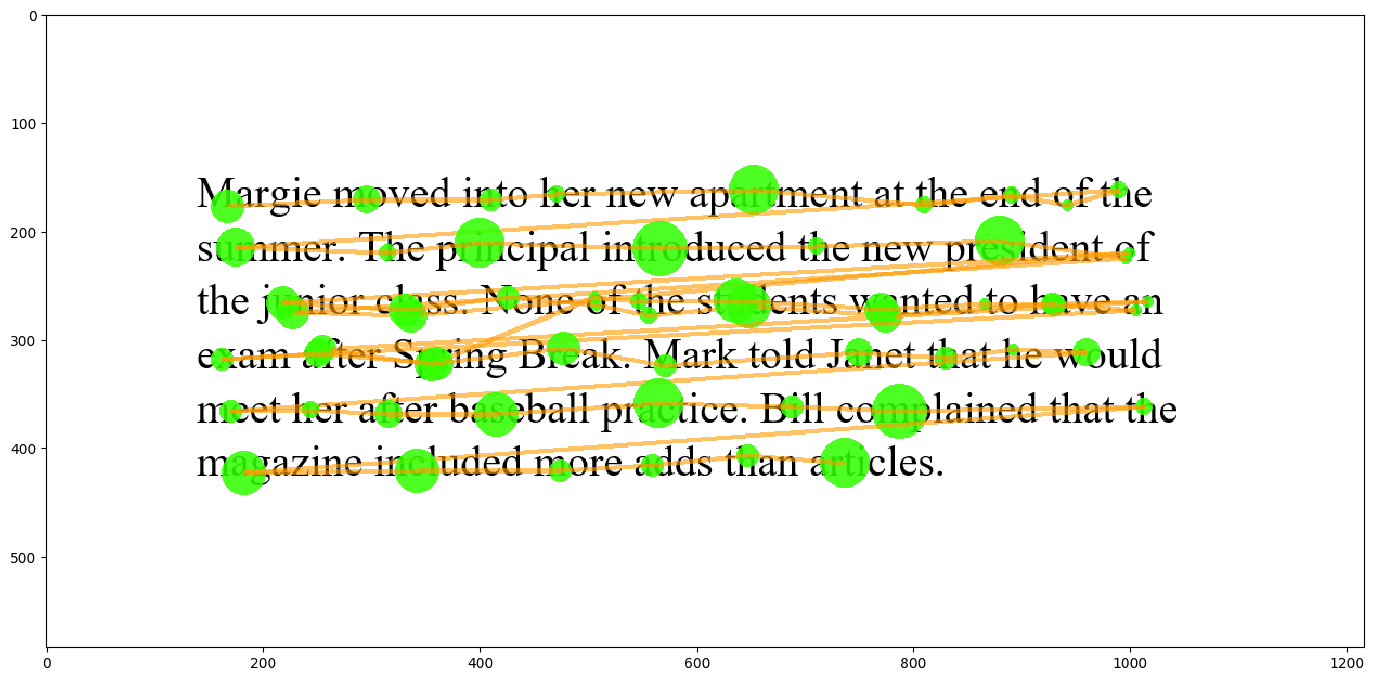

In [4]:
# draw original correct fixations

correction.draw_fixation('synthetic_text.png', data['robot1'].copy())

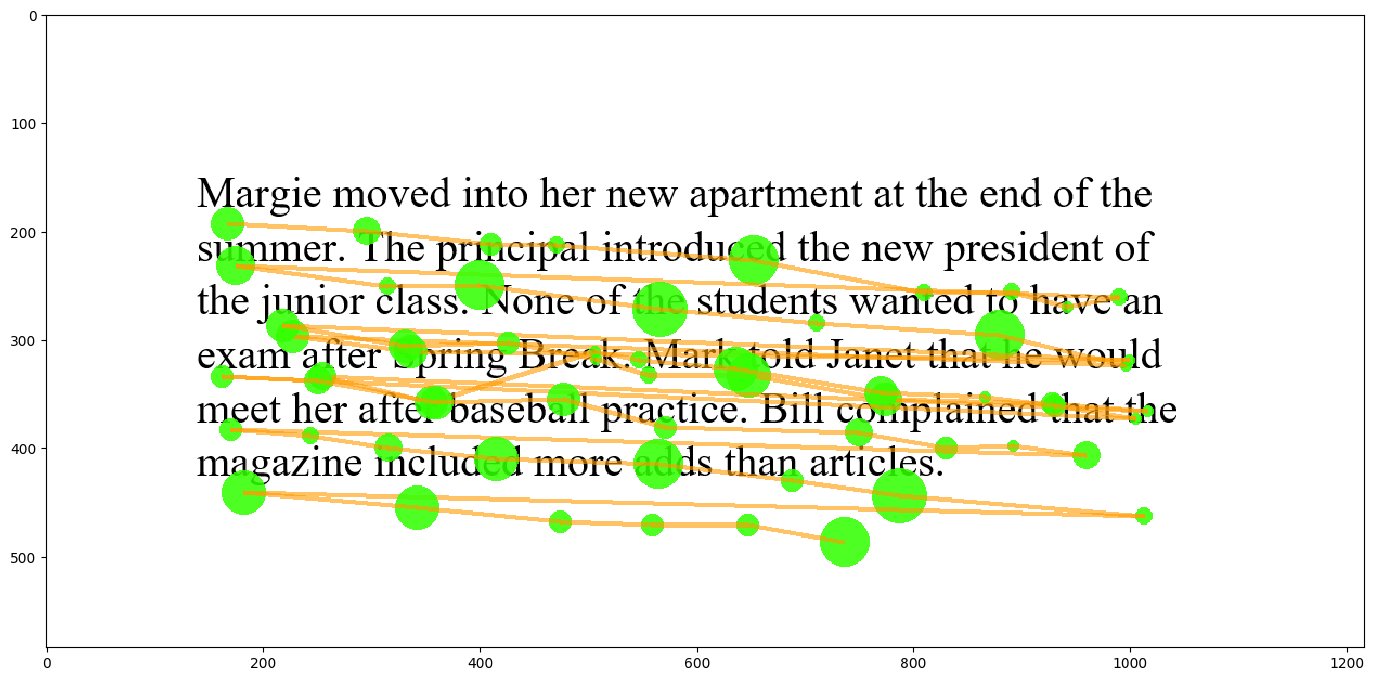

In [5]:
# generate slope over the correct trial
error_test = correction.error_slope(0.1, data['robot1'].copy())

# draw the trial with added error
correction.draw_fixation('synthetic_text.png', error_test)

0.5833333333333334
60
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
fixations:  60
match_list:  60


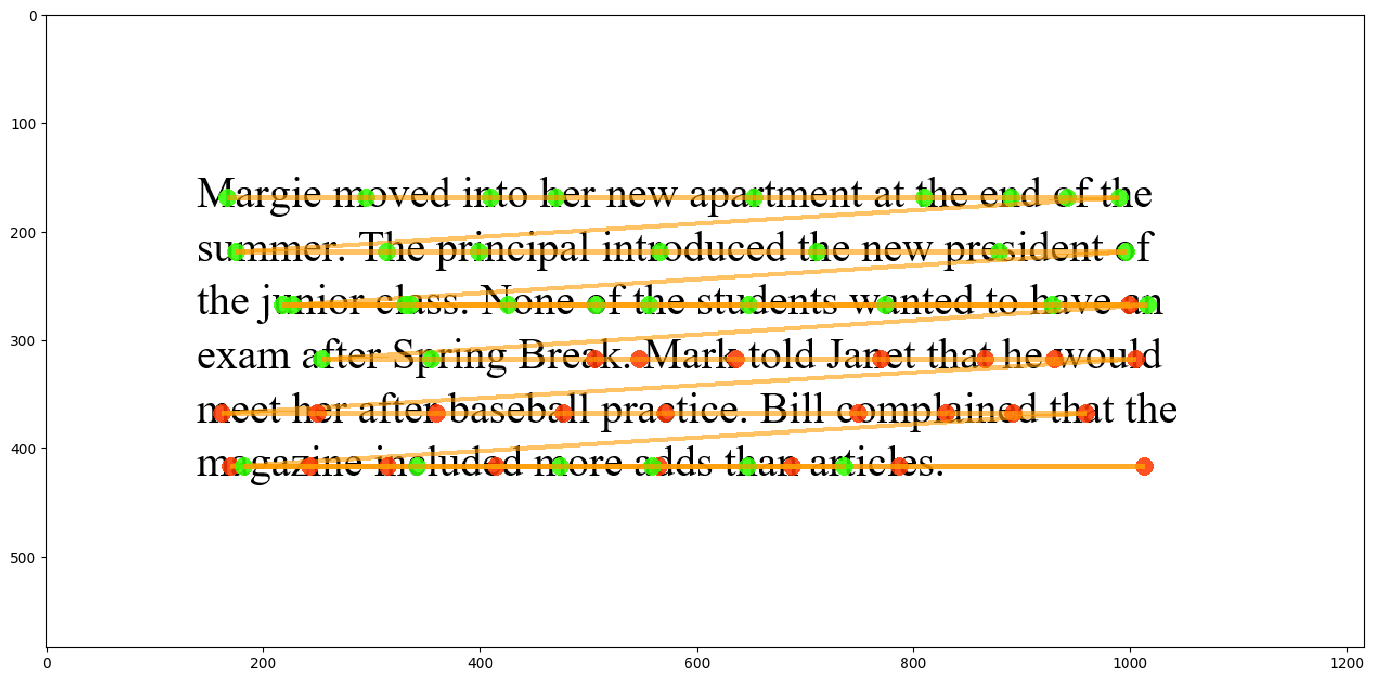

In [6]:
# find the center of each word, we need this for warp algorithm
word_centers = correction.find_word_centers(aoi)
word_centers = np.array(word_centers.copy(), dtype=int)

# warp correction
np_array = np.array(error_test.copy(), dtype=int)
durations = np.delete(np_array, 0, 1)
durations = np.delete(durations, 0, 1)
np_array = np.delete(np_array, 2, 1)

# run warp
warp_correction = algo.warp(np_array, word_centers)

# this is a cool function that checks the quality of the correction
percentage, match_list = correction.correction_quality(aoi, data['robot1'].copy(), warp_correction)
print(percentage)
print(len(match_list))
print(match_list)

# this is a cool function that draws the correction in red if the algorithm made a mistake
correction.draw_correction('synthetic_text.png', warp_correction, match_list)

This concludes the example I wanted to show you of running an error generator, then correcting the data, then seeing how well the correction algorithm did.  You will need to repeat the same concept for a bunch of algorithms in the next section.

# Comparing algorithms with Slope error:

In [8]:
attach_results = [[],[],[],[],[],[],[],[],[],[],[]]
chain_results = [[],[],[],[],[],[],[],[],[],[],[]]
regress_results = [[],[],[],[],[],[],[],[],[],[],[]]
warp_results = [[],[],[],[],[],[],[],[],[],[],[]]
# Initializing the remaining 6 algorithms
cluster_results = [[],[],[],[],[],[],[],[],[],[],[]]
compare_results = [[],[],[],[],[],[],[],[],[],[],[]]
merge_results = [[],[],[],[],[],[],[],[],[],[],[]]
segment_results = [[],[],[],[],[],[],[],[],[],[],[]]
split_results = [[],[],[],[],[],[],[],[],[],[],[]]
stretch_results = [[],[],[],[],[],[],[],[],[],[],[]]


word_centers = correction.find_word_centers(aoi)
word_centers = np.array(word_centers.copy(), dtype=int)

duration_word_centers = correction.find_word_centers_and_duration(aois_with_tokens)
duration_word_centers = np.array(duration_word_centers.copy(), dtype=int)

# MAKE SURE YOU RUN THIS 100 TIMES, NOT JUST ONE!!!
for robot_index in tqdm(range(100)):
    
    for error_probability in range(0, 11):
        
        slope = -0.125 + (error_probability * 0.025)
        error_test = correction.error_slope(slope, data['robot' + str(robot_index)].copy())

        # attach correction - 1
        np_array = np.array(error_test.copy())
        attach_correction = algo.attach(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, data['robot' + str(robot_index)].copy(), attach_correction)
        attach_results[error_probability].append(percentage)

        # chain correction - 2
        np_array = np.array(error_test.copy())
        chain_correction = algo.chain(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, data['robot' + str(robot_index)].copy(), chain_correction)
        chain_results[error_probability].append(percentage)
        
        # regress correction - 3
        np_array = np.array(error_test.copy())
        regress_correction = algo.regress(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, data['robot' + str(robot_index)].copy(), regress_correction)
        regress_results[error_probability].append(percentage)
        
        # warp correction - 4
        np_array = np.array(error_test.copy(), dtype=int)
        durations = np.delete(np_array, 0, 1)
        durations = np.delete(durations, 0, 1)
        np_array = np.delete(np_array, 2, 1)
        
        warp_correction = algo.warp(np_array, word_centers)
        percentage, match_list = correction.correction_quality(aoi, data['robot' + str(robot_index)].copy(), warp_correction)
        warp_results[error_probability].append(percentage)

        if percentage < 1:
            # correction.draw_correction('synthetic_text.png', warp_correction, match_list)
            print("robot:", robot_index, "    error probability:", error_probability)

        # cluster correction - 5
        np_array = np.array(error_test.copy())
        cluster_correction = algo.cluster(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, data['robot' + str(robot_index)].copy(), cluster_correction)
        cluster_results[error_probability].append(percentage)

        # compare correction - 6 which takes in fixation_XY, word_XY
        np_array = np.array(error_test.copy())
        compare_correction = algo.compare(np_array, duration_word_centers)
        percentage, match_list = correction.correction_quality(aoi, data['robot' + str(robot_index)].copy(), compare_correction)
        compare_results[error_probability].append(percentage)

        # merge correction - 7
        np_array = np.array(error_test.copy())
        merge_correction = algo.merge(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, data['robot' + str(robot_index)].copy(), merge_correction)
        merge_results[error_probability].append(percentage)

        # segment correction - 8
        np_array = np.array(error_test.copy())
        segment_correction = algo.segment(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, data['robot' + str(robot_index)].copy(), segment_correction)
        segment_results[error_probability].append(percentage)

        # split correction - 9
        np_array = np.array(error_test.copy())
        split_correction = algo.split(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, data['robot' + str(robot_index)].copy(), split_correction)
        split_results[error_probability].append(percentage)

        # stretch correction - 10
        np_array = np.array(error_test.copy())
        stretch_correction = algo.stretch(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, data['robot' + str(robot_index)].copy(), stretch_correction)
        stretch_results[error_probability].append(percentage)


  0%|          | 0/100 [00:00<?, ?it/s]

robot: 0     error probability: 0
robot: 0     error probability: 1
robot: 0     error probability: 2
robot: 0     error probability: 3
robot: 0     error probability: 4
robot: 0     error probability: 5
robot: 0     error probability: 6
robot: 0     error probability: 7
robot: 0     error probability: 8
robot: 0     error probability: 9
robot: 0     error probability: 10


  1%|          | 1/100 [00:08<14:38,  8.87s/it]

robot: 1     error probability: 0
robot: 1     error probability: 1
robot: 1     error probability: 2
robot: 1     error probability: 3
robot: 1     error probability: 4
robot: 1     error probability: 5
robot: 1     error probability: 6
robot: 1     error probability: 7
robot: 1     error probability: 8
robot: 1     error probability: 9
robot: 1     error probability: 10


  3%|▎         | 3/100 [00:27<14:25,  8.93s/it]

robot: 3     error probability: 0
robot: 3     error probability: 1
robot: 3     error probability: 2
robot: 3     error probability: 3
robot: 3     error probability: 4
robot: 3     error probability: 5
robot: 3     error probability: 6
robot: 3     error probability: 7
robot: 3     error probability: 8
robot: 3     error probability: 9
robot: 3     error probability: 10


  4%|▍         | 4/100 [00:40<16:51, 10.54s/it]

robot: 4     error probability: 0
robot: 4     error probability: 1
robot: 4     error probability: 2
robot: 4     error probability: 3
robot: 4     error probability: 4
robot: 4     error probability: 5
robot: 4     error probability: 6
robot: 4     error probability: 7
robot: 4     error probability: 8
robot: 4     error probability: 9
robot: 4     error probability: 10


  6%|▌         | 6/100 [01:00<15:55, 10.16s/it]

robot: 6     error probability: 0
robot: 6     error probability: 1
robot: 6     error probability: 2
robot: 6     error probability: 3
robot: 6     error probability: 4
robot: 6     error probability: 5
robot: 6     error probability: 6
robot: 6     error probability: 7
robot: 6     error probability: 8
robot: 6     error probability: 9
robot: 6     error probability: 10


  8%|▊         | 8/100 [01:18<14:17,  9.33s/it]

robot: 8     error probability: 0
robot: 8     error probability: 1
robot: 8     error probability: 2
robot: 8     error probability: 3
robot: 8     error probability: 4
robot: 8     error probability: 5
robot: 8     error probability: 6
robot: 8     error probability: 7
robot: 8     error probability: 8
robot: 8     error probability: 9
robot: 8     error probability: 10


  9%|▉         | 9/100 [01:26<13:52,  9.15s/it]

robot: 9     error probability: 0
robot: 9     error probability: 1
robot: 9     error probability: 2
robot: 9     error probability: 3
robot: 9     error probability: 4
robot: 9     error probability: 5
robot: 9     error probability: 6
robot: 9     error probability: 7
robot: 9     error probability: 8
robot: 9     error probability: 9
robot: 9     error probability: 10


 11%|█         | 11/100 [01:44<13:14,  8.93s/it]

robot: 11     error probability: 0
robot: 11     error probability: 1
robot: 11     error probability: 2
robot: 11     error probability: 3
robot: 11     error probability: 4
robot: 11     error probability: 5
robot: 11     error probability: 6
robot: 11     error probability: 7
robot: 11     error probability: 8
robot: 11     error probability: 9
robot: 11     error probability: 10


 12%|█▏        | 12/100 [01:54<13:16,  9.06s/it]

robot: 12     error probability: 0
robot: 12     error probability: 1
robot: 12     error probability: 2
robot: 12     error probability: 3
robot: 12     error probability: 4
robot: 12     error probability: 5
robot: 12     error probability: 6
robot: 12     error probability: 7
robot: 12     error probability: 8
robot: 12     error probability: 9
robot: 12     error probability: 10


 14%|█▍        | 14/100 [02:19<15:11, 10.60s/it]

robot: 14     error probability: 0
robot: 14     error probability: 1
robot: 14     error probability: 2
robot: 14     error probability: 3
robot: 14     error probability: 4
robot: 14     error probability: 5
robot: 14     error probability: 6
robot: 14     error probability: 7
robot: 14     error probability: 8
robot: 14     error probability: 9
robot: 14     error probability: 10


 16%|█▌        | 16/100 [02:37<13:35,  9.71s/it]

robot: 16     error probability: 0
robot: 16     error probability: 1
robot: 16     error probability: 2
robot: 16     error probability: 3
robot: 16     error probability: 4
robot: 16     error probability: 5
robot: 16     error probability: 6
robot: 16     error probability: 7
robot: 16     error probability: 8
robot: 16     error probability: 9
robot: 16     error probability: 10


 17%|█▋        | 17/100 [02:47<13:45,  9.94s/it]

robot: 17     error probability: 9
robot: 17     error probability: 10


 19%|█▉        | 19/100 [03:06<12:52,  9.54s/it]

robot: 19     error probability: 0
robot: 19     error probability: 1
robot: 19     error probability: 2
robot: 19     error probability: 3
robot: 19     error probability: 4
robot: 19     error probability: 5
robot: 19     error probability: 6
robot: 19     error probability: 7
robot: 19     error probability: 8
robot: 19     error probability: 9
robot: 19     error probability: 10


 20%|██        | 20/100 [03:16<13:07,  9.85s/it]

robot: 20     error probability: 0
robot: 20     error probability: 1
robot: 20     error probability: 2
robot: 20     error probability: 3
robot: 20     error probability: 4
robot: 20     error probability: 5
robot: 20     error probability: 6
robot: 20     error probability: 7
robot: 20     error probability: 8
robot: 20     error probability: 9
robot: 20     error probability: 10


 22%|██▏       | 22/100 [03:35<12:14,  9.42s/it]

robot: 22     error probability: 0
robot: 22     error probability: 1
robot: 22     error probability: 2
robot: 22     error probability: 3
robot: 22     error probability: 4
robot: 22     error probability: 5
robot: 22     error probability: 6
robot: 22     error probability: 7
robot: 22     error probability: 8
robot: 22     error probability: 9
robot: 22     error probability: 10


 23%|██▎       | 23/100 [03:46<13:01, 10.14s/it]

robot: 23     error probability: 0
robot: 23     error probability: 1
robot: 23     error probability: 2
robot: 23     error probability: 3
robot: 23     error probability: 4
robot: 23     error probability: 5
robot: 23     error probability: 6
robot: 23     error probability: 7
robot: 23     error probability: 8
robot: 23     error probability: 9
robot: 23     error probability: 10


 27%|██▋       | 27/100 [04:22<11:06,  9.12s/it]

robot: 27     error probability: 0
robot: 27     error probability: 1
robot: 27     error probability: 2
robot: 27     error probability: 3
robot: 27     error probability: 4
robot: 27     error probability: 5
robot: 27     error probability: 6
robot: 27     error probability: 7
robot: 27     error probability: 8
robot: 27     error probability: 9
robot: 27     error probability: 10


 28%|██▊       | 28/100 [04:33<11:39,  9.72s/it]

robot: 28     error probability: 0
robot: 28     error probability: 1
robot: 28     error probability: 2
robot: 28     error probability: 3
robot: 28     error probability: 4
robot: 28     error probability: 5
robot: 28     error probability: 6
robot: 28     error probability: 7
robot: 28     error probability: 8
robot: 28     error probability: 9
robot: 28     error probability: 10


 32%|███▏      | 32/100 [05:09<10:15,  9.05s/it]

robot: 32     error probability: 0
robot: 32     error probability: 1
robot: 32     error probability: 2
robot: 32     error probability: 3
robot: 32     error probability: 4
robot: 32     error probability: 5
robot: 32     error probability: 6
robot: 32     error probability: 7
robot: 32     error probability: 8
robot: 32     error probability: 9
robot: 32     error probability: 10


 34%|███▍      | 34/100 [05:28<10:16,  9.34s/it]

robot: 34     error probability: 0
robot: 34     error probability: 8
robot: 34     error probability: 9
robot: 34     error probability: 10


 36%|███▌      | 36/100 [05:50<10:32,  9.89s/it]

robot: 36     error probability: 8
robot: 36     error probability: 9
robot: 36     error probability: 10


 37%|███▋      | 37/100 [05:58<09:55,  9.46s/it]

robot: 37     error probability: 0
robot: 37     error probability: 1
robot: 37     error probability: 2
robot: 37     error probability: 3
robot: 37     error probability: 4
robot: 37     error probability: 5
robot: 37     error probability: 6
robot: 37     error probability: 7
robot: 37     error probability: 8
robot: 37     error probability: 9
robot: 37     error probability: 10


 38%|███▊      | 38/100 [06:08<10:02,  9.73s/it]

robot: 38     error probability: 0
robot: 38     error probability: 1
robot: 38     error probability: 2
robot: 38     error probability: 3
robot: 38     error probability: 4
robot: 38     error probability: 5
robot: 38     error probability: 6
robot: 38     error probability: 7
robot: 38     error probability: 8
robot: 38     error probability: 9
robot: 38     error probability: 10


 39%|███▉      | 39/100 [06:20<10:23, 10.22s/it]

robot: 39     error probability: 0
robot: 39     error probability: 1
robot: 39     error probability: 2
robot: 39     error probability: 3
robot: 39     error probability: 4
robot: 39     error probability: 5
robot: 39     error probability: 6
robot: 39     error probability: 7
robot: 39     error probability: 8
robot: 39     error probability: 9
robot: 39     error probability: 10


 40%|████      | 40/100 [06:30<10:18, 10.30s/it]

robot: 40     error probability: 0
robot: 40     error probability: 1
robot: 40     error probability: 2
robot: 40     error probability: 3
robot: 40     error probability: 4
robot: 40     error probability: 5
robot: 40     error probability: 6
robot: 40     error probability: 7
robot: 40     error probability: 8
robot: 40     error probability: 9
robot: 40     error probability: 10


 41%|████      | 41/100 [06:43<10:43, 10.90s/it]

robot: 41     error probability: 0
robot: 41     error probability: 1
robot: 41     error probability: 2
robot: 41     error probability: 3
robot: 41     error probability: 4
robot: 41     error probability: 5
robot: 41     error probability: 6
robot: 41     error probability: 7
robot: 41     error probability: 8
robot: 41     error probability: 9
robot: 41     error probability: 10


 42%|████▏     | 42/100 [06:54<10:38, 11.01s/it]

robot: 42     error probability: 0
robot: 42     error probability: 1
robot: 42     error probability: 2
robot: 42     error probability: 3
robot: 42     error probability: 4
robot: 42     error probability: 5
robot: 42     error probability: 6
robot: 42     error probability: 7
robot: 42     error probability: 8
robot: 42     error probability: 9
robot: 42     error probability: 10


 43%|████▎     | 43/100 [07:04<10:10, 10.70s/it]

robot: 43     error probability: 0
robot: 43     error probability: 1
robot: 43     error probability: 2
robot: 43     error probability: 3
robot: 43     error probability: 4
robot: 43     error probability: 5
robot: 43     error probability: 6
robot: 43     error probability: 7
robot: 43     error probability: 8
robot: 43     error probability: 9
robot: 43     error probability: 10


 46%|████▌     | 46/100 [07:33<09:00, 10.00s/it]

robot: 46     error probability: 0
robot: 46     error probability: 1
robot: 46     error probability: 2
robot: 46     error probability: 3
robot: 46     error probability: 4
robot: 46     error probability: 5
robot: 46     error probability: 6
robot: 46     error probability: 7
robot: 46     error probability: 8
robot: 46     error probability: 9
robot: 46     error probability: 10


 48%|████▊     | 48/100 [07:53<08:36,  9.92s/it]

robot: 48     error probability: 0
robot: 48     error probability: 1
robot: 48     error probability: 2
robot: 48     error probability: 3
robot: 48     error probability: 4
robot: 48     error probability: 5
robot: 48     error probability: 6
robot: 48     error probability: 7
robot: 48     error probability: 8
robot: 48     error probability: 9
robot: 48     error probability: 10


 51%|█████     | 51/100 [08:19<07:26,  9.12s/it]

robot: 51     error probability: 0
robot: 51     error probability: 1
robot: 51     error probability: 2
robot: 51     error probability: 3
robot: 51     error probability: 4
robot: 51     error probability: 5
robot: 51     error probability: 6
robot: 51     error probability: 7
robot: 51     error probability: 8
robot: 51     error probability: 9
robot: 51     error probability: 10


 53%|█████▎    | 53/100 [08:37<07:04,  9.03s/it]

robot: 53     error probability: 0
robot: 53     error probability: 1
robot: 53     error probability: 2
robot: 53     error probability: 3
robot: 53     error probability: 4
robot: 53     error probability: 5
robot: 53     error probability: 6
robot: 53     error probability: 7
robot: 53     error probability: 8
robot: 53     error probability: 9
robot: 53     error probability: 10


 56%|█████▌    | 56/100 [09:07<06:53,  9.40s/it]

robot: 56     error probability: 0
robot: 56     error probability: 1
robot: 56     error probability: 2
robot: 56     error probability: 3
robot: 56     error probability: 4
robot: 56     error probability: 5
robot: 56     error probability: 6
robot: 56     error probability: 7
robot: 56     error probability: 8
robot: 56     error probability: 9
robot: 56     error probability: 10


 58%|█████▊    | 58/100 [09:24<06:18,  9.01s/it]

robot: 58     error probability: 0
robot: 58     error probability: 1
robot: 58     error probability: 2
robot: 58     error probability: 3
robot: 58     error probability: 4
robot: 58     error probability: 5
robot: 58     error probability: 6
robot: 58     error probability: 7
robot: 58     error probability: 8
robot: 58     error probability: 9
robot: 58     error probability: 10


 59%|█████▉    | 59/100 [09:35<06:34,  9.63s/it]

robot: 59     error probability: 0
robot: 59     error probability: 1
robot: 59     error probability: 2
robot: 59     error probability: 3
robot: 59     error probability: 4
robot: 59     error probability: 5
robot: 59     error probability: 6
robot: 59     error probability: 7
robot: 59     error probability: 8
robot: 59     error probability: 9
robot: 59     error probability: 10


 61%|██████    | 61/100 [09:55<06:21,  9.77s/it]

robot: 61     error probability: 0
robot: 61     error probability: 1
robot: 61     error probability: 2
robot: 61     error probability: 3
robot: 61     error probability: 4
robot: 61     error probability: 5
robot: 61     error probability: 6
robot: 61     error probability: 7
robot: 61     error probability: 8
robot: 61     error probability: 9
robot: 61     error probability: 10


 62%|██████▏   | 62/100 [10:10<07:06, 11.21s/it]

robot: 62     error probability: 0
robot: 62     error probability: 1
robot: 62     error probability: 2
robot: 62     error probability: 3
robot: 62     error probability: 4
robot: 62     error probability: 5
robot: 62     error probability: 6
robot: 62     error probability: 7
robot: 62     error probability: 8
robot: 62     error probability: 9
robot: 62     error probability: 10


 63%|██████▎   | 63/100 [10:23<07:12, 11.69s/it]

robot: 63     error probability: 0
robot: 63     error probability: 1
robot: 63     error probability: 2
robot: 63     error probability: 3
robot: 63     error probability: 4
robot: 63     error probability: 5
robot: 63     error probability: 6
robot: 63     error probability: 7
robot: 63     error probability: 8
robot: 63     error probability: 9
robot: 63     error probability: 10


 64%|██████▍   | 64/100 [10:33<06:47, 11.31s/it]

robot: 64     error probability: 0
robot: 64     error probability: 1
robot: 64     error probability: 2
robot: 64     error probability: 3
robot: 64     error probability: 4
robot: 64     error probability: 5
robot: 64     error probability: 6
robot: 64     error probability: 7
robot: 64     error probability: 8
robot: 64     error probability: 9
robot: 64     error probability: 10


 67%|██████▋   | 67/100 [11:02<05:37, 10.22s/it]

robot: 67     error probability: 0
robot: 67     error probability: 1
robot: 67     error probability: 2
robot: 67     error probability: 3
robot: 67     error probability: 4
robot: 67     error probability: 5
robot: 67     error probability: 6
robot: 67     error probability: 7
robot: 67     error probability: 8
robot: 67     error probability: 9
robot: 67     error probability: 10


 68%|██████▊   | 68/100 [11:14<05:40, 10.65s/it]

robot: 68     error probability: 0
robot: 68     error probability: 1
robot: 68     error probability: 2
robot: 68     error probability: 3
robot: 68     error probability: 4
robot: 68     error probability: 5
robot: 68     error probability: 6
robot: 68     error probability: 7
robot: 68     error probability: 8
robot: 68     error probability: 9
robot: 68     error probability: 10


 69%|██████▉   | 69/100 [11:23<05:11, 10.04s/it]

robot: 69     error probability: 9
robot: 69     error probability: 10


 74%|███████▍  | 74/100 [12:11<04:14,  9.79s/it]

robot: 74     error probability: 0
robot: 74     error probability: 1
robot: 74     error probability: 2
robot: 74     error probability: 3
robot: 74     error probability: 4
robot: 74     error probability: 5
robot: 74     error probability: 6
robot: 74     error probability: 7
robot: 74     error probability: 8
robot: 74     error probability: 9
robot: 74     error probability: 10


 75%|███████▌  | 75/100 [12:22<04:10, 10.00s/it]

robot: 75     error probability: 0
robot: 75     error probability: 1
robot: 75     error probability: 2
robot: 75     error probability: 3
robot: 75     error probability: 4
robot: 75     error probability: 5
robot: 75     error probability: 6
robot: 75     error probability: 7
robot: 75     error probability: 8
robot: 75     error probability: 9
robot: 75     error probability: 10


 77%|███████▋  | 77/100 [12:43<03:59, 10.41s/it]

robot: 77     error probability: 0
robot: 77     error probability: 1
robot: 77     error probability: 2
robot: 77     error probability: 3
robot: 77     error probability: 4
robot: 77     error probability: 5
robot: 77     error probability: 6
robot: 77     error probability: 7
robot: 77     error probability: 8
robot: 77     error probability: 9
robot: 77     error probability: 10


 79%|███████▉  | 79/100 [13:11<04:08, 11.85s/it]

robot: 79     error probability: 0
robot: 79     error probability: 1
robot: 79     error probability: 2
robot: 79     error probability: 3
robot: 79     error probability: 4
robot: 79     error probability: 5
robot: 79     error probability: 6
robot: 79     error probability: 7
robot: 79     error probability: 8
robot: 79     error probability: 9
robot: 79     error probability: 10


 80%|████████  | 80/100 [13:22<03:54, 11.73s/it]

robot: 80     error probability: 0
robot: 80     error probability: 1
robot: 80     error probability: 2
robot: 80     error probability: 3
robot: 80     error probability: 4
robot: 80     error probability: 5
robot: 80     error probability: 6
robot: 80     error probability: 7
robot: 80     error probability: 8
robot: 80     error probability: 9
robot: 80     error probability: 10


 81%|████████  | 81/100 [13:40<04:15, 13.42s/it]

robot: 81     error probability: 0
robot: 81     error probability: 1
robot: 81     error probability: 2
robot: 81     error probability: 3
robot: 81     error probability: 4
robot: 81     error probability: 5
robot: 81     error probability: 6
robot: 81     error probability: 7
robot: 81     error probability: 8
robot: 81     error probability: 9
robot: 81     error probability: 10


 83%|████████▎ | 83/100 [14:01<03:24, 12.05s/it]

robot: 83     error probability: 0
robot: 83     error probability: 1
robot: 83     error probability: 2
robot: 83     error probability: 3
robot: 83     error probability: 4
robot: 83     error probability: 5
robot: 83     error probability: 6
robot: 83     error probability: 7
robot: 83     error probability: 8
robot: 83     error probability: 9
robot: 83     error probability: 10


 84%|████████▍ | 84/100 [14:12<03:04, 11.51s/it]

robot: 84     error probability: 0
robot: 84     error probability: 1
robot: 84     error probability: 2
robot: 84     error probability: 3
robot: 84     error probability: 4
robot: 84     error probability: 5
robot: 84     error probability: 6
robot: 84     error probability: 7
robot: 84     error probability: 8
robot: 84     error probability: 9
robot: 84     error probability: 10


 85%|████████▌ | 85/100 [14:23<02:51, 11.47s/it]

robot: 85     error probability: 0
robot: 85     error probability: 1
robot: 85     error probability: 2
robot: 85     error probability: 3
robot: 85     error probability: 4
robot: 85     error probability: 5
robot: 85     error probability: 6
robot: 85     error probability: 7
robot: 85     error probability: 8
robot: 85     error probability: 9
robot: 85     error probability: 10


 86%|████████▌ | 86/100 [14:35<02:42, 11.62s/it]

robot: 86     error probability: 0
robot: 86     error probability: 1
robot: 86     error probability: 2
robot: 86     error probability: 3
robot: 86     error probability: 4
robot: 86     error probability: 5
robot: 86     error probability: 6
robot: 86     error probability: 7
robot: 86     error probability: 8
robot: 86     error probability: 9
robot: 86     error probability: 10


 89%|████████▉ | 89/100 [15:06<01:55, 10.52s/it]

robot: 89     error probability: 0
robot: 89     error probability: 1
robot: 89     error probability: 2
robot: 89     error probability: 3
robot: 89     error probability: 4
robot: 89     error probability: 5
robot: 89     error probability: 6
robot: 89     error probability: 7
robot: 89     error probability: 8
robot: 89     error probability: 9
robot: 89     error probability: 10


 92%|█████████▏| 92/100 [15:42<01:28, 11.06s/it]

robot: 92     error probability: 0
robot: 92     error probability: 1
robot: 92     error probability: 2
robot: 92     error probability: 3
robot: 92     error probability: 4
robot: 92     error probability: 5
robot: 92     error probability: 6
robot: 92     error probability: 7
robot: 92     error probability: 8
robot: 92     error probability: 9
robot: 92     error probability: 10


 94%|█████████▍| 94/100 [16:04<01:05, 10.92s/it]

robot: 94     error probability: 0
robot: 94     error probability: 1
robot: 94     error probability: 2
robot: 94     error probability: 3
robot: 94     error probability: 4
robot: 94     error probability: 5
robot: 94     error probability: 6
robot: 94     error probability: 7
robot: 94     error probability: 8
robot: 94     error probability: 9
robot: 94     error probability: 10


 96%|█████████▌| 96/100 [16:28<00:46, 11.59s/it]

robot: 96     error probability: 0
robot: 96     error probability: 1
robot: 96     error probability: 2
robot: 96     error probability: 3
robot: 96     error probability: 4
robot: 96     error probability: 5
robot: 96     error probability: 6
robot: 96     error probability: 7
robot: 96     error probability: 8
robot: 96     error probability: 9
robot: 96     error probability: 10


 97%|█████████▋| 97/100 [16:39<00:34, 11.41s/it]

robot: 97     error probability: 0
robot: 97     error probability: 1
robot: 97     error probability: 2
robot: 97     error probability: 3
robot: 97     error probability: 4
robot: 97     error probability: 5
robot: 97     error probability: 6
robot: 97     error probability: 7
robot: 97     error probability: 8
robot: 97     error probability: 9
robot: 97     error probability: 10


100%|██████████| 100/100 [17:09<00:00, 10.30s/it]


In [9]:
import statistics

def mean_error_group(results):
    new_list = []
    
    for result in results:
        new_list.append(statistics.mean(result))
        
    return new_list

In [10]:
mean_attach_results = mean_error_group(attach_results)
mean_chain_results = mean_error_group(chain_results)
mean_regress_results = mean_error_group(regress_results)
mean_warp_results = mean_error_group(warp_results)
mean_cluster_results = mean_error_group(cluster_results)
mean_compare_results = mean_error_group(compare_results)
mean_merge_results = mean_error_group(merge_results)
mean_segment_results = mean_error_group(segment_results)
mean_split_results = mean_error_group(split_results)
mean_stretch_results = mean_error_group(stretch_results)

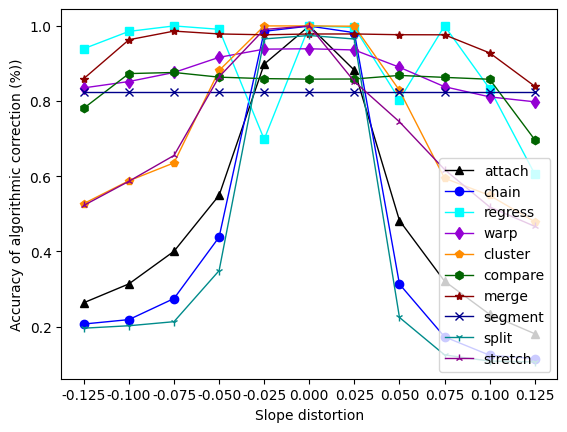

In [11]:
import matplotlib.pyplot as plt
plt.plot(mean_attach_results, color='Black', linewidth=1, marker='^')
plt.plot(mean_chain_results, color='Blue', linewidth=1, marker='o')
plt.plot(mean_regress_results, color='Aqua', linewidth=1, marker='s')
plt.plot(mean_warp_results, color='DarkViolet', linewidth=1, marker='d')
plt.plot(mean_cluster_results, color='DarkOrange', linewidth=1, marker='p')
plt.plot(mean_compare_results, color='DarkGreen', linewidth=1, marker='h')
plt.plot(mean_merge_results, color='DarkRed', linewidth=1, marker='*')
plt.plot(mean_segment_results, color='DarkBlue', linewidth=1, marker='x')
plt.plot(mean_split_results, color='DarkCyan', linewidth=1, marker='1')
plt.plot(mean_stretch_results, color='DarkMagenta', linewidth=1, marker='2')

plt.legend(['attach', 'chain', 'regress', 'warp', 'cluster', 'compare', 'merge', 'segment', 'split', 'stretch'], loc='lower right')
plt.ylabel('Accuracy of algorithmic correction (%))')
plt.xlabel('Slope distortion')
# x tick labels between -0.1 and
x_ticks_labels = ['-0.125', '-0.100', '-0.075', '-0.050', '-0.025', '0.000', '0.025', '0.050', '0.075', '0.100', '0.125']
plt.xticks(range(0, 11), x_ticks_labels)
#plt.savefig("noise_comparison.png")
plt.show()

In [12]:
print("mean attach:", statistics.mean(mean_attach_results))
print("mean chain:", statistics.mean(mean_chain_results))
print("mean regress:", statistics.mean(mean_regress_results))
print("mean warp:", statistics.mean(mean_warp_results))
print("mean cluster:", statistics.mean(mean_cluster_results))
print("mean compare:", statistics.mean(mean_compare_results))
print("mean merge:", statistics.mean(mean_merge_results))
print("mean segment:", statistics.mean(mean_segment_results))
print("mean split:", statistics.mean(mean_split_results))
print("mean stretch:", statistics.mean(mean_stretch_results))

mean attach: 0.5020680211896532
mean chain: 0.4389829894041682
mean regress: 0.8957314658292048
mean warp: 0.8755010691517923
mean cluster: 0.7347570983765542
mean compare: 0.8415931440850805
mean merge: 0.9492697891198962
mean segment: 0.8248087685713085
mean split: 0.40244422938901064
mean stretch: 0.7108061483769103
